# Towards steering multi-AI interactions with SAEs
by Casey Barkan

Associated Google Doc:
https://docs.google.com/document/d/1De_swqc0-bT7kcyh1Ok275l3-iD-JY3KYQXpL9p8xgI/edit?usp=sharing

# Getting started (using code from SAELens/tutorial_2_0.ipynb)

In [1]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens sae-dashboard
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pandas as pd

# Imports for displaying vis in Colab / notebook

torch.set_grad_enabled(False)

# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.8 MB/s eta 0:00:00
   ━

I will use GPT2-small and the pre-trained SAE 7-res-jb.

In [2]:
from sae_lens import SAE, HookedSAETransformer

model = HookedSAETransformer.from_pretrained("gpt2-small", device = device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb", # <- Release name
    sae_id = "blocks.7.hook_resid_pre", # <- SAE id (not always a hook point!)
    device = device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


blocks.7.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

In [5]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

sae.use_error_term = True

# Step #1: Find features relevant to two-way conversation with a pre-trained SAE.


In [6]:
# Comparing activations from two prompts

prompt1 = "Alice: Hi Bob.\nBob: I'm busy, go away!\nAlice: Fine. Goodbye."
print('prompt1:')
print(prompt1)

prompt2 = "Alice: Hi Bob.\nBob: Hey Alice, nice to see you!\nAlice: How have you been?"
print('\nprompt2:')
print(prompt2)

prompt1:
Alice: Hi Bob.
Bob: I'm busy, go away!
Alice: Fine. Goodbye.

prompt2:
Alice: Hi Bob.
Bob: Hey Alice, nice to see you!
Alice: How have you been?


In [27]:
_, cache = model.run_with_cache_with_saes([prompt1, prompt2], saes=[sae])
print([(k, v.shape) for k,v in cache.items() if "sae" in k])

feature_activation_df = pd.DataFrame(cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu().numpy(),
                                     index = [f"feature_{i}" for i in range(sae.cfg.d_sae)],
)
feature_activation_df.columns = ["prompt1"]
feature_activation_df["prompt2"] = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][1, -1, :].cpu().numpy()
feature_activation_df["diff"]= feature_activation_df["prompt1"] - feature_activation_df["prompt2"]

fig = px.line(
    feature_activation_df,
    title="Differences in feature activations between the two prompts",
    labels={"index": "Feature", "value": "Activation"},
)

# hide the x-ticks
fig.update_xaxes(showticklabels=False)
fig.update_layout(width=1100)
fig.show()

[('blocks.7.hook_resid_pre.hook_sae_input', torch.Size([2, 25, 768])), ('blocks.7.hook_resid_pre.hook_sae_acts_pre', torch.Size([2, 25, 24576])), ('blocks.7.hook_resid_pre.hook_sae_acts_post', torch.Size([2, 25, 24576])), ('blocks.7.hook_resid_pre.hook_sae_recons', torch.Size([2, 25, 768])), ('blocks.7.hook_resid_pre.hook_sae_error', torch.Size([2, 25, 768])), ('blocks.7.hook_resid_pre.hook_sae_output', torch.Size([2, 25, 768]))]


Now look at the 5 features with the biggest difference in their activations:

In [9]:
diff = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][1, -1, :].cpu() - cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu()
vals, inds = torch.topk(torch.abs(diff), 5)
for val, ind in zip(vals, inds):
    print(f"Feature {ind} had a difference of {val:.2f}")
    html = get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=ind)
    display(IFrame(html, width=1200, height=300))

Feature 14519 had a difference of 58.05


Feature 4679 had a difference of 24.46


Feature 1141 had a difference of 21.00


Feature 24263 had a difference of 11.04


Feature 10777 had a difference of 10.44


Feature 10777 looks relevant. Autointerp description: "sentences that are the end of dialogues or conversations."

Now, use code for steering from tutorial_2_0.ipynb:

In [10]:
# instantiate an object to hold activations from a dataset
from sae_lens import ActivationsStore

# a convenient way to instantiate an activation store is to use the from_sae method
activation_store = ActivationsStore.from_sae(
    model=model,
    sae=sae,
    streaming=True,
    # fairly conservative parameters here so can use same for larger
    # models without running out of memory.
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=32,
    device=device,
)

In [11]:
from tqdm import tqdm
from functools import partial

def find_max_activation(model, sae, activation_store, feature_idx, num_batches=100):
    '''
    Find the maximum activation for a given feature index. This is useful for
    calibrating the right amount of the feature to add.
    '''
    max_activation = 0.0

    pbar = tqdm(range(num_batches))
    for _ in pbar:
        tokens = activation_store.get_batch_tokens()

        _, cache = model.run_with_cache(
            tokens,
            stop_at_layer=sae.cfg.hook_layer + 1,
            names_filter=[sae.cfg.hook_name]
        )
        sae_in = cache[sae.cfg.hook_name]
        feature_acts = sae.encode(sae_in).squeeze()

        feature_acts = feature_acts.flatten(0, 1)
        batch_max_activation = feature_acts[:, feature_idx].max().item()
        max_activation = max(max_activation, batch_max_activation)

        pbar.set_description(f"Max activation: {max_activation:.4f}")

    return max_activation

def steering(activations, hook, steering_strength=1.0, steering_vector=None, max_act=1.0):
    # Note if the feature fires anyway, we'd be adding to that here.
    return activations + max_act * steering_strength * steering_vector

def generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=1.0, max_new_tokens=95):
    #input_ids = model.to_tokens(prompt, prepend_bos=sae.cfg.prepend_bos)
    input_ids = model.to_tokens(prompt, prepend_bos=False)

    steering_vector = sae.W_dec[steering_feature].to(model.cfg.device)

    steering_hook = partial(
        steering,
        steering_vector=steering_vector,
        steering_strength=steering_strength,
        max_act=max_act
    )

    # standard transformerlens syntax for a hook context for generation
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, steering_hook)]):
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos = False if device == "mps" else True,
            prepend_bos = sae.cfg.prepend_bos,
        )

    return model.tokenizer.decode(output[0])

In [15]:
# Find max activation for feature of interest:
steering_feature = 10777

# Pre-computed max_act:
max_act = 20.3996

"""
# NOTE: I have pre-computed the value of max_act for feature 10777 because this
# function takes a long time to run. To re-compute the value, uncomment this code.

max_act = find_max_activation(model, sae, activation_store, steering_feature)
print(f"Maximum activation for feature {steering_feature}: {max_act:.4f}")
"""

'\n# NOTE: I have pre-computed the value of max_act because this function takes a long\n# time to run. To re-compute the value, uncomment this code.\n\nmax_act = find_max_activation(model, sae, activation_store, steering_feature)\nprint(f"Maximum activation for feature {steering_feature}: {max_act:.4f}")\n'

# Step #2: Steering two-way conversations with the discovered feature.


Prompt to initiate two-way conversation:

In [16]:
prompt = "Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nice weather we're having.\nDebby:"
print(prompt)

Chris: Hi Debby.
Debby: Hi Chris!
Chris: Nice weather we're having.
Debby:


Let's look at some examples of steered conversations:

In [18]:
steered0 = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=0.0)
print("Steered0 text:")
print(steered0)

steered1 = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=1.0)
print("Steered1 text:")
print(steered1)

steered2 = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=2.0)
print("Steered2 text:")
print(steered2)

  0%|          | 0/95 [00:00<?, ?it/s]

Steered0 text:
Chris: Hi Debby.
Debby: Hi Chris!
Chris: Nice weather we're having.
Debby: We're getting the weather right, thanks.
Chris: Thank you.
Debby: Thanks.
Chris: I think it's going to be pretty good.
Debby: I think it's going to be good.
Chris: I don't know if it's going to be good or bad.
Debby: I don't know if it's going to be bad or good.
Chris: I'm just wondering if we can keep up.


  0%|          | 0/95 [00:00<?, ?it/s]

Steered1 text:
Chris: Hi Debby.
Debby: Hi Chris!
Chris: Nice weather we're having.
Debby: I'm sure we'll see you next week.
Chris: If you can't be here, I'll be.
Debby: I'm so sorry. I'm sorry I can't be here.
Chris: I'm sorry. I'm sorry.
Debby: I'm sorry. I'm sorry.
Chris: I'm sorry.
I'm sorry.
Debby: I'm sorry.
Debby: I'm sorry.
Chris


  0%|          | 0/95 [00:00<?, ?it/s]

Steered2 text:
Chris: Hi Debby.
Debby: Hi Chris!
Chris: Nice weather we're having.
Debby: I Can I

Chris:

Okay.

[Sigh]

[Exit]

[B-

Chris: I

I

I

I

I

[Sigh]

[Cha

Sigh]

[Cha]

[

I

I

I

I

I

I

[Sigh]




Now let's collect data for several trials:

In [19]:
num_trials = 4
strengths = [0., 0.5, 1., 1.5]
data = []
for trial in range(num_trials):
  for strength in strengths:
    convo = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=strength)
    data.append({"Trial": trial, "Strength": strength, "Convo": convo})

convo_df = pd.DataFrame(data)
print(convo_df)

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

    Trial  Strength                                              Convo
0       0       0.0  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
1       0       0.5  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
2       0       1.0  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
3       0       1.5  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
4       1       0.0  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
5       1       0.5  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
6       1       1.0  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
7       1       1.5  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
8       2       0.0  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
9       2       0.5  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
10      2       1.0  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
11      2       1.5  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
12      3       0.0  Chris: Hi Debby.\nDebby: Hi Chris!\nChris: Nic...
13    

In [20]:
# My function to compute verbosity stats:

def get_verbosity_stats(text):
    """
    Finds the mean length of each person's statements in the conversation.
    """

    def evaluate_line(line):
        """
        Evaluates:
        - Whether line begins a new statement, e.g. "Chris: Hello..."
        - Length of statement
        of first word is a colon, then the line begins a new statement.

        Output:
            boolean: True if line begins a new statement
            int: length of line after the character name
        """
        if len(line) == 0:
            return False, 0
        elif line[0].isupper() and ':' == line.split()[0][-1]:
            opener_length = len(line.split()[0])
            return True, len(line) - opener_length
        else:
            return False, len(line)

    lines = text.split('\n')
    current_statement_len = 0
    statement_len_list = []
    for line in lines:
        is_new_statement, added_length = evaluate_line(line)
        if is_new_statement:
            statement_len_list += [current_statement_len]
            current_statement_len = added_length
        else:
            current_statement_len += added_length

    statement_len_list += [current_statement_len]
    statement_len_list = statement_len_list[1:] # Removes dummy element
    #print(statement_len_list)

    #statement_len_mean = np.mean(statement_len_list)
    #statement_len_var = np.var(statement_len_list)
    return statement_len_list

46 [10, 10, 27, 60, 18, 24, 28, 27, 20, 30, 7, 11, 20, 10, 10, 27, 27, 21, 11, 43, 52, 32, 6, 22, 39, 10, 10, 27, 10, 6, 61, 156, 89, 17, 10, 10, 27, 10, 76, 36, 6, 66, 9, 9, 9, 29]
53 [10, 10, 27, 60, 50, 34, 11, 34, 87, 22, 10, 10, 27, 29, 21, 29, 29, 21, 21, 21, 21, 21, 21, 0, 10, 10, 27, 35, 17, 34, 5, 18, 33, 39, 34, 60, 10, 10, 27, 8, 24, 11, 21, 24, 24, 5, 5, 11, 5, 5, 5, 5, 8]
84 [10, 10, 27, 16, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 27, 55, 25, 44, 9, 42, 32, 6, 32, 6, 13, 10, 10, 27, 36, 0, 14, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 27, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5]
47 [10, 10, 27, 90, 10, 10, 27, 0, 13, 0, 10, 31, 10, 73, 10, 10, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 27, 4, 40]


Text(0, 0.5, 'Remark length')

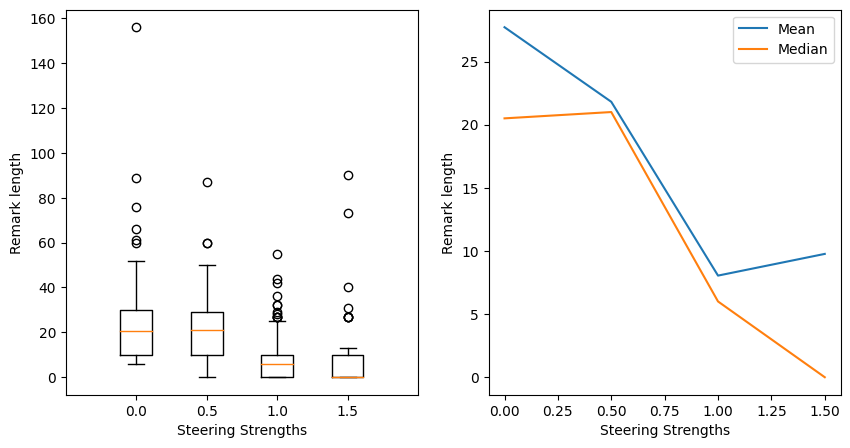

In [22]:
length_lists = []
for strength in strengths:
  #print('strength=',strength)
  length_list = []
  for convo in convo_df[convo_df['Strength']==strength]["Convo"].tolist():
    length_list += get_verbosity_stats(convo)
  length_lists += [length_list]
  print(len(length_list),length_list)

import numpy as np
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.boxplot(length_lists, positions=strengths);
ax1.set_xlabel('Steering Strengths')
ax1.set_ylabel('Remark length')

ax2.plot(strengths,[np.mean(x) for x in length_lists])
ax2.plot(strengths,[np.median(x) for x in length_lists])
ax2.legend(['Mean', 'Median'])
ax2.set_xlabel('Steering Strengths')
ax2.set_ylabel('Remark length')

#Step #3: Searching for features specific to 3-way conversation:

Prompts designed to activate features relevant to cyclical references in 3-way conversation.

In [23]:
prompt3 = "A: I like B.\nB: I like C.\nC: I like A.\nA: I like B.\nB: I like C.\nC: I like A."
print('prompt3')
print(prompt3)

prompt4 = "A: I like B.\nB: I like A.\nA: I like B.\nB: I like A.\nC: I like B.\nA: I like B.\nB: I like A."
print('\nprompt4')
print(prompt4)

prompt3
A: I like B.
B: I like C.
C: I like A.
A: I like B.
B: I like C.
C: I like A.

prompt4
A: I like B.
B: I like A.
A: I like B.
B: I like A.
C: I like B.
A: I like B.
B: I like A.


Checking differences in feature activations between the prompts:

In [30]:
sae.use_error_term = True
_, cache2 = model.run_with_cache_with_saes([prompt3, prompt4], saes=[sae])
print([(k, v.shape) for k,v in cache2.items() if "sae" in k])

feature_activation_df2 = pd.DataFrame(cache2['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu().numpy(),
                                     index = [f"feature_{i}" for i in range(sae.cfg.d_sae)],
)
feature_activation_df2.columns = ["prompt3"]
feature_activation_df2["prompt4"] = cache2['blocks.7.hook_resid_pre.hook_sae_acts_post'][1, -1, :].cpu().numpy()
feature_activation_df2["diff"]= feature_activation_df2["prompt3"] - feature_activation_df2["prompt4"]

fig = px.line(
    feature_activation_df2,
    title="Differences in feature activations between prompt3 and prompt4",
    labels={"index": "Feature", "value": "Activation"},
)

# hide the x-ticks
fig.update_xaxes(showticklabels=False)
fig.update_layout(width=1100)
fig.show()

[('blocks.7.hook_resid_pre.hook_sae_input', torch.Size([2, 49, 768])), ('blocks.7.hook_resid_pre.hook_sae_acts_pre', torch.Size([2, 49, 24576])), ('blocks.7.hook_resid_pre.hook_sae_acts_post', torch.Size([2, 49, 24576])), ('blocks.7.hook_resid_pre.hook_sae_recons', torch.Size([2, 49, 768])), ('blocks.7.hook_resid_pre.hook_sae_error', torch.Size([2, 49, 768])), ('blocks.7.hook_resid_pre.hook_sae_output', torch.Size([2, 49, 768]))]


In [31]:
diff = cache2['blocks.7.hook_resid_pre.hook_sae_acts_post'][1, -1, :].cpu() - cache2['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu()
vals, inds = torch.topk(torch.abs(diff), 5)
for val, ind in zip(vals, inds):
    print(f"Feature {ind} had a difference of {val:.2f}")
    html = get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=ind)
    display(IFrame(html, width=1200, height=300))

Feature 14519 had a difference of 47.57


Feature 9663 had a difference of 24.07


Feature 23346 had a difference of 20.78


Feature 18327 had a difference of 11.78


Feature 8948 had a difference of 9.68


In [32]:
# Find max activation for feature of interest:
steering_feature = 23346

# Pre-computed max_act:
max_act = 17.0

"""
# NOTE: I have pre-computed the value of max_act for feature 10777 because this
# function takes a long time to run. To re-compute the value, uncomment this code.

max_act = find_max_activation(model, sae, activation_store, steering_feature)
print(f"Maximum activation for feature {steering_feature}: {max_act:.4f}")
"""

'\n# NOTE: I have pre-computed the value of max_act for feature 10777 because this \n# function takes a long time to run. To re-compute the value, uncomment this code.\n\nmax_act = find_max_activation(model, sae, activation_store, steering_feature)\nprint(f"Maximum activation for feature {steering_feature}: {max_act:.4f}")\n'

Prompt to initiate conversation:

In [33]:
prompt = "A: Hello B.\nB: Hi C.\nC: Hey"
print(prompt)

A: Hello B.
B: Hi C.
C: Hey


Generate examples of steered conversations:

In [34]:
# Generate text with steering
steering_feature = 23346
max_act = 17.0 # obtained with find_max_activation(), which is slow to run.
steered_0 = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=0.0)
print("steered_0 text:")
print(steered_0)

steered_p5 = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=0.5)
print("steered_p5 text:")
print(steered_p5)

steered_1 = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=1.0)
print("steered_1 text:")
print(steered_1)

  0%|          | 0/95 [00:00<?, ?it/s]

steered_0 text:
A: Hello B.
B: Hi C.
C: Hey, I just wanted to ask you about this.
B: I've heard about it.
C: Well, I think it's a bit like...
B: I'm sorry, I mean, you're not really going to tell me what you're going to tell me.
C: Well, I think I know what you're going to tell me.
B: You know, I have been reading a lot lately. I was thinking that it's


  0%|          | 0/95 [00:00<?, ?it/s]

steered_p5 text:
A: Hello B.
B: Hi C.
C: Hey C.
A: Hello B.
B: Hello C.
B: Hello B.
C: Hello B.
C: Hello B.
A: Hello B.
C: Hello B.
C: Hello B.
C: Hello B.
C: Hello B.
C: Hello B.
C: Hello B.
C: Hello B.
A: Hello B.
C: Hello B.
A:


  0%|          | 0/95 [00:00<?, ?it/s]

steered_1 text:
A: Hello B.
B: Hi C.
C: Hey!
C: Hey!

C: Hello B.

C: Hi C.

C: Hello B.

C: Hi C.

C: Hello B.

C: Hello B.

C: Hello B.

C: Hello B.

C: Hello B.

C: Hello B.

C: Hello B.

C: Hello B.

C: Hello


In [35]:
# My function for counting references to other participants in the conversation:

def count_references(text):
    num_remarks = 0
    num_references = 0

    references = [" A ", " B ", " C ", " A.", " B.", " C."]

    def contains_ref(s):
        for ref in references:
            if ref in s:
                return True
        return False

    lines = text.split('\n')
    for line in lines:
        if line[0:2] == "A:" or line[0:2] == "B:" or line[0:2] == "C:":
            num_remarks += 1
            if contains_ref(line[2:]):
                num_references += 1
        else:
            pass

    return num_references, num_remarks

In [36]:
# Generate data for several trials

#def generate_text(strength):
#  return 'a'*int(strength*5)

num_trials = 10
strengths = [0., 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4]
data = []
for trial in range(num_trials):
  for strength in strengths:
    print('trial', trial, 'strength', strength)
    convo = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=strength)
    data.append({"Trial": trial, "Strength": strength, "Convo": convo})

threeway_df = pd.DataFrame(data)
print(threeway_df)

trial 0 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 0 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 0 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 0 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 0 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 0 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 0 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 0 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 1 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 2 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 3 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 4 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 5 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 6 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 7 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 8 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 0.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 0.4


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 0.6


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 0.8


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 1.2


  0%|          | 0/95 [00:00<?, ?it/s]

trial 9 strength 1.4


  0%|          | 0/95 [00:00<?, ?it/s]

    Trial  Strength                                              Convo
0       0       0.0  A: Hello B.\nB: Hi C.\nC: Hey, hi!\nC: Hi!\nC:...
1       0       0.2  A: Hello B.\nB: Hi C.\nC: Hey C.\nC: What's wr...
2       0       0.4  A: Hello B.\nB: Hi C.\nC: Hey C.\nD: Hey D.\nE...
3       0       0.6  A: Hello B.\nB: Hi C.\nC: Hey C.\nC: Hi C.\nC:...
4       0       0.8  A: Hello B.\nB: Hi C.\nC: Hey B.\nC: Hello C.\...
..    ...       ...                                                ...
75      9       0.6  A: Hello B.\nB: Hi C.\nC: Hey D.\nD: What's up...
76      9       0.8  A: Hello B.\nB: Hi C.\nC: Hey C.\nB: Hi C.\n\n...
77      9       1.0  A: Hello B.\nB: Hi C.\nC: Hey C.\n\nD: Hello D...
78      9       1.2  A: Hello B.\nB: Hi C.\nC: Hey C.\n\nB: Hello C...
79      9       1.4  A: Hello B.\nB: Hi C.\nC: Hey\n\nB: Hello\n\nC...

[80 rows x 3 columns]


10 [0.09523809523809523, 0.5, 1.0, 0.6666666666666666, 0.3, 0.6666666666666666, 0.10526315789473684, 0.5, 0.2, 0.6666666666666666]
10 [0.75, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.1111111111111111, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]
10 [1.0, 0.6666666666666666, 0.7368421052631579, 0.2222222222222222, 1.0, 0.9473684210526315, 0.8947368421052632, 0.11538461538461539, 0.14285714285714285, 0.15789473684210525]
10 [0.9473684210526315, 0.2857142857142857, 0.9473684210526315, 0.13043478260869565, 0.9473684210526315, 0.10526315789473684, 0.4, 0.9473684210526315, 0.5, 0.4]
10 [0.9411764705882353, 0.9411764705882353, 1.0, 0.16666666666666666, 0.10526315789473684, 0.9285714285714286, 1.0, 1.0, 0.2857142857142857, 1.0]
10 [0.14285714285714285, 1.0, 0.5, 0.6666666666666666, 1.0, 0.16666666666666666, 1.0, 0.42857142857142855, 0.9375, 0.3333333333333333]
10 [0.5, 0.09090909090909091, 0.2857142857142857, 0.14285714

Text(0, 0.5, 'Ref. fraction')

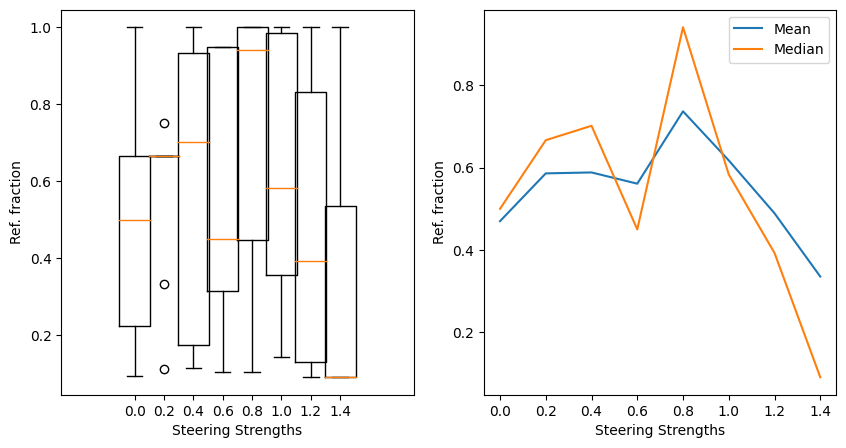

In [37]:
ref_fractions_lists = []
for strength in strengths:
  #print('strength=',strength)
  ref_fractions = []
  for convo in threeway_df[threeway_df['Strength']==strength]["Convo"].tolist():
    refs, remarks = count_references(convo)
    ref_fractions += [refs/remarks]
  ref_fractions_lists += [ref_fractions]
  print(len(ref_fractions),ref_fractions)


import numpy as np
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.boxplot(ref_fractions_lists, positions=strengths);
ax1.set_xlabel('Steering Strengths')
ax1.set_ylabel('Ref. fraction')

ax2.plot(strengths,[np.mean(x) for x in ref_fractions_lists])
ax2.plot(strengths,[np.median(x) for x in ref_fractions_lists])
ax2.legend(['Mean', 'Median'])
ax2.set_xlabel('Steering Strengths')
ax2.set_ylabel('Ref. fraction')